In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

n_timesteps = 60
test_set_size = 0.2

#strings
test_set_key = 'test'
training_set_key = 'train'
open_key = 'Open'
adam_optimizer = 'adam'
mse_loss = 'mean_squared_error'

#model params
optimizer = adam_optimizer
loss = mse_loss
dropout_rate = 0.2
lstm_layer_size = 50
dense_layer_size = 1

In [70]:
def to_array(df):
    return df.values

def process_data(df, set_key):
    data = df[open_key]

    #split
    if set_key == training_set_key:
        data = to_array(data)[:int(len(data)*(1-test_set_size))]
    else:
        data = to_array(data)[int(len(data)*(1-test_set_size)):]

    data = data.reshape(
        (data.shape[0], 1)
    )

    #scale
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data)

    #split
    X, y = [], []
    for i in range(n_timesteps, scaled_data.shape[0]):
        X.append(scaled_data[i-n_timesteps:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y

def build_model(n_cols):
    model = Sequential()
    model.add(LSTM(units=lstm_layer_size, return_sequences=True, input_shape=(n_cols, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_layer_size, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_layer_size, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_layer_size))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_layer_size))
    model.compile(optimizer=optimizer, loss=loss)

    return model

In [61]:
#load data
df = pd.read_csv('../data/train.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1986-03-13,0.056367,0.064656,0.056367,0.061893,1031788800,0.0,0.0
1,1986-03-14,0.061893,0.065209,0.061893,0.064103,308160000,0.0,0.0
2,1986-03-17,0.064103,0.065761,0.064103,0.065209,133171200,0.0,0.0
3,1986-03-18,0.065209,0.065761,0.062998,0.063551,67766400,0.0,0.0
4,1986-03-19,0.063551,0.064103,0.061893,0.062446,47894400,0.0,0.0


In [71]:
#scale the data
X_train, y_train = process_data(df, training_set_key)

#TODO fix y_test
X_test, y_test = process_data(df, test_set_key)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6944, 60, 1), (6944,), (1692, 60, 1), (1692,))

In [67]:
#build model
brain = build_model(X_train.shape[1])

brain.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)               

In [68]:
#training
brain.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
217/217 [==============================] - 9s 42ms/step - loss: 1.6835e-04
Epoch 2/100
217/217 [==============================] - 9s 40ms/step - loss: 6.0899e-05
Epoch 3/100
217/217 [==============================] - 9s 41ms/step - loss: 4.9924e-05
Epoch 4/100
217/217 [==============================] - 9s 41ms/step - loss: 4.3520e-05
Epoch 5/100
217/217 [==============================] - 9s 41ms/step - loss: 3.6978e-05
Epoch 6/100
217/217 [==============================] - 9s 42ms/step - loss: 3.7709e-05
Epoch 7/100
217/217 [==============================] - 10s 44ms/step - loss: 3.2916e-05
Epoch 8/100
217/217 [==============================] - 9s 43ms/step - loss: 3.4743e-05
Epoch 9/100
217/217 [==============================] - 9s 43ms/step - loss: 3.2743e-05
Epoch 10/100
217/217 [==============================] - 10s 44ms/step - loss: 3.0960e-05
Epoch 11/100
217/217 [==============================] - 10s 45ms/step - loss: 2.9876e-05
Epoch 12/100
217/217 [================

In [75]:
#predict - tego bedziemy uzywac w apce
y_hat = brain.predict(X_test)
y_hat = scaler.inverse_transform(y_hat)

mean_squared_error(y_test, y_hat)

608.1507161896634

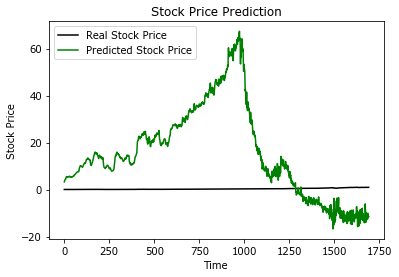

In [77]:
plt.plot(y_test, color = 'black', label = 'Real Stock Price')
plt.plot(y_hat, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [79]:
brain.save('../data/brain.h5')

#load like this
#model = load_model('first_try.h5')